In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from hydra import initialize, compose
from rdkit import Chem
from ergochemics.draw import draw_reaction, draw_molecule
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import SVG
from tqdm import tqdm
from minedatabase.pickaxe import Pickaxe

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [ ]:
expansion_name = "2_steps_250728_benchmark_starters_aplusb_True"
cpd_df = pd.read_parquet(Path(cfg.processed_data) / f"{expansion_name}_compound_metrics.parquet")
cpd_df = cpd_df.groupby(["expansion", "gen"]).agg({"fan_out": ["mean", "std"]}).reset_index()
cpd_df.head(24)

expansion gen     fan_out  \
                                                                 mean   
0   2_steps_ccm_aa_rules_imt_rules_w_coreactants_a...   0  164.793103   
1   2_steps_ccm_aa_rules_imt_rules_w_coreactants_a...   1   60.714286   
2   2_steps_ccm_aa_rules_mechinferred_dt_15_rules_...   0  166.689655   
3   2_steps_ccm_aa_rules_mechinferred_dt_15_rules_...   1   36.008237   
4   2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w...   0   86.724138   
5   2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w...   1   21.681499   
6   2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w...   0  119.310345   
7   2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w...   1   26.777070   
8   2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w...   0  137.034483   
9   2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w...   1   28.583650   
10  2_steps_ccm_aa_rules_mechinferred_dt_98_rules_...   0  186.724138   
11  2_steps_ccm_aa_rules_mechinferred_dt_98_rules_...   1   44.057851   
12  2_steps_ccm_aa_rules_mechinformed_rules_w_core...   0  111.896552   
13  2_steps_ccm_aa_rules_mechinformed_rules_w_core...   1   26.923077   
14  2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreact...   0  387.931034   
15  2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreact...   1  214.558548   
16  2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreact...   0   68.068966   
17  2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreact...   1   20.415094   
18  2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreact...   0   30.034483   
19  2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreact...   1   11.021053   
20  2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreact...   0   13.758621   
21  2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreact...   1    7.352941   
22  2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...   0   13.137931   
23  2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...   1    6.560386   

                 
            std  
0    292.132110  
1     41.250251  
2    204.523855  
3     27.099102  
4    117.871570  
5     15.475309  
6    154.962231  
7     20.730161  
8    191.619877  
9     21.224775  
10   261.401429  
11    37.749986  
12   194.829659  
13    20.073932  
14  1015.279094  
15   194.008915  
16    75.831548  
17    13.402387  
18    35.764590  
19     5.461734  
20     6.711691  
21     3.603326  
22     7.740082  
23     3.122884

In [ ]:
known_reactions = {}

for exp_name in cpd_df["expansion"].unique():
    rule_set = exp_name.split("_rules_")[1]
    fn = Path(cfg.raw_data) / f"mapped_known_reactions_x_{rule_set}_rules.parquet"
    print(fn)
    mapped_rxns = pd.read_parquet(fn)
    rxns = set(mapped_rxns["smarts"])
    known_reactions[exp_name] = rxns

/home/stef/cgr/data/raw/mapped_sprhea_240310_v3_mapped_no_subunits_x_imt_rules.parquet
/home/stef/cgr/data/raw/mapped_sprhea_240310_v3_mapped_no_subunits_x_mechinferred_dt_15_rules.parquet
/home/stef/cgr/data/raw/mapped_sprhea_240310_v3_mapped_no_subunits_x_mechinferred_dt_2_rules.parquet
/home/stef/cgr/data/raw/mapped_sprhea_240310_v3_mapped_no_subunits_x_mechinferred_dt_3_rules.parquet
/home/stef/cgr/data/raw/mapped_sprhea_240310_v3_mapped_no_subunits_x_mechinferred_dt_6_rules.parquet
/home/stef/cgr/data/raw/mapped_sprhea_240310_v3_mapped_no_subunits_x_mechinferred_dt_98_rules.parquet
/home/stef/cgr/data/raw/mapped_sprhea_240310_v3_mapped_no_subunits_x_mechinformed_rules.parquet
/home/stef/cgr/data/raw/mapped_sprhea_240310_v3_mapped_no_subunits_x_rc_plus_0_rules.parquet
/home/stef/cgr/data/raw/mapped_sprhea_240310_v3_mapped_no_subunits_x_rc_plus_1_rules.parquet
/home/stef/cgr/data/raw/mapped_sprhea_240310_v3_mapped_no_subunits_x_rc_plus_2_rules.parquet
/home/stef/cgr/data/raw/mapped_

In [36]:
rxn_df = pd.read_parquet(Path(cfg.processed_data) / f"{expansion_name}_reaction_metrics.parquet")
print(len(rxn_df))
rxn_df["known"] = rxn_df.apply(
    lambda row: row["smarts"] in known_reactions[row["expansion"]],
    axis=1
)
rxn_df = rxn_df[~rxn_df["known"]]
print(len(rxn_df))
rxn_df.head()

894127
891245


,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,known
0,Ra5466f30b2eff8d962354506782f3c774e2dbccfeabcc...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C...,[O:1]=[c:2]1[cH:3][cH:4][n:5]([CH:6]2[O:7][CH:...,1,1.000000,Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C...,6795,[813_1],2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
1,R1a6f3d7e229c81ffd5e77b63a4191e793232130cbc0e0...,O=C(O)CCC(=O)O.CC(N)C(=O)O>>CC(NC(=O)CCC(=O)O)...,[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...,1,0.848875,O=C(O)CCC(=O)O.NC(CCC(=O)O)C(=O)O>>O=C(O)CCC(=...,197,"[8_0_0, 8_0_0_0, 8_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
2,Ra9e6706c0b8df38fa1056bb4ad1ac443a60e95f3e02f1...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C...,[O:1]=[c:2]1[cH:3][cH:4][n:5]([CH:6]2[O:7][CH:...,1,0.960000,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C...,19866,[558_1],2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
3,Rec6d7525917f77e5f6c7a5942c1b7197b67be650c7476...,O=C(O)CCC(=O)O.O=C(O)CCC(=O)O>>O.O=C(O)CCC(=O)...,[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...,0,0.710047,O=C(O)CCC(=O)O.CCCCCCCCCCCCCCCCOCC(O)COP(=O)(O...,4622,"[167_0_1, 167_0_0, 167_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
4,R3b25a7e0bed159020e2a34dc51c3cf7529c6ec4038177...,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,0,0.947368,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,2190,"[333_1, 382_1, 631_1]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False


In [ ]:
rxn_df.groupby("expansion").agg({"dxgb_label": ["mean", "std"], "max_rxn_sim": ["mean", "std"]}).head(12)

dxgb_label            \
                                                         mean       std   
expansion                                                                 
2_steps_ccm_aa_rules_imt_rules_w_coreactants_ap...   0.733032  0.443380   
2_steps_ccm_aa_rules_mechinferred_dt_15_rules_w...   0.801724  0.399563   
2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w_...   0.808696  0.394186   
2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w_...   0.804348  0.397567   
2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w_...   0.810345  0.392876   
2_steps_ccm_aa_rules_mechinferred_dt_98_rules_w...   0.827869  0.378270   
2_steps_ccm_aa_rules_mechinformed_rules_w_corea...   0.810345  0.393729   
2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreacta...   0.722222  0.448637   
2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreacta...   0.800000  0.400787   
2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreacta...   0.803150  0.398403   
2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreacta...   0.816479  0.387820   
2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreacta...   0.830508  0.375823   

                                                   max_rxn_sim                
                                                          mean           std  
expansion                                                                     
2_steps_ccm_aa_rules_imt_rules_w_coreactants_ap...    0.998986  1.507189e-02  
2_steps_ccm_aa_rules_mechinferred_dt_15_rules_w...    0.998655  2.048164e-02  
2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w_...    0.996171  3.351598e-02  
2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w_...    0.996171  3.351598e-02  
2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w_...    0.992840  5.733634e-02  
2_steps_ccm_aa_rules_mechinferred_dt_98_rules_w...    0.995270  3.368755e-02  
2_steps_ccm_aa_rules_mechinformed_rules_w_corea...    0.998922  1.160596e-02  
2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreacta...    0.962686  1.193205e-01  
2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreacta...    0.996528  2.249903e-02  
2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreacta...    0.998906  1.742933e-02  
2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreacta...    1.000000  1.419757e-16  
2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreacta...    1.000000  1.408209e-16

In [44]:
ct_df = rxn_df.groupby("expansion").size().reset_index(name="n_rxns")
ct_df.head()

,expansion,n_rxns
0,2_steps_ccm_aa_rules_imt_rules_w_coreactants_a...,76993
1,2_steps_ccm_aa_rules_mechinferred_dt_15_rules_...,22400
2,2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w...,9573
3,2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w...,13010
4,2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w...,15491


In [ ]:
exp_names = list(rxn_df.expansion.unique())
perm = [0, 1, 6, 5, 4, 3, 2, 7, 8, 9, 10, 11]  # for plotting in order of increasing RC
exp_names = [exp_names[p] for p in perm]
exp_labels = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': "Mechinformed",
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': "RC + 0",
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': "RC + 1",
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': "RC + 2",
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': "RC + 3",
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': "RC + 4",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_91_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.91",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_13_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.13",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_04_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.04",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_02_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.02",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_01_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.01"
}

colors = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("green"),
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_91_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_13_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_04_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_02_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_01_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=1.0)
}

legend_elements = [
    Patch(facecolor=col, edgecolor='w', label=exp_labels[name])
    for name, col in colors.items()
]

In [47]:
print(matplotlib.colors.to_rgba("blue"))
print(matplotlib.colors.to_rgba("purple"))
print(matplotlib.colors.to_rgba("black"))
print(matplotlib.colors.to_rgba("green"))

(0.0, 0.0, 1.0, 1.0)
(0.5019607843137255, 0.0, 0.5019607843137255, 1.0)
(0.0, 0.0, 0.0, 1.0)
(0.0, 0.5019607843137255, 0.0, 1.0)


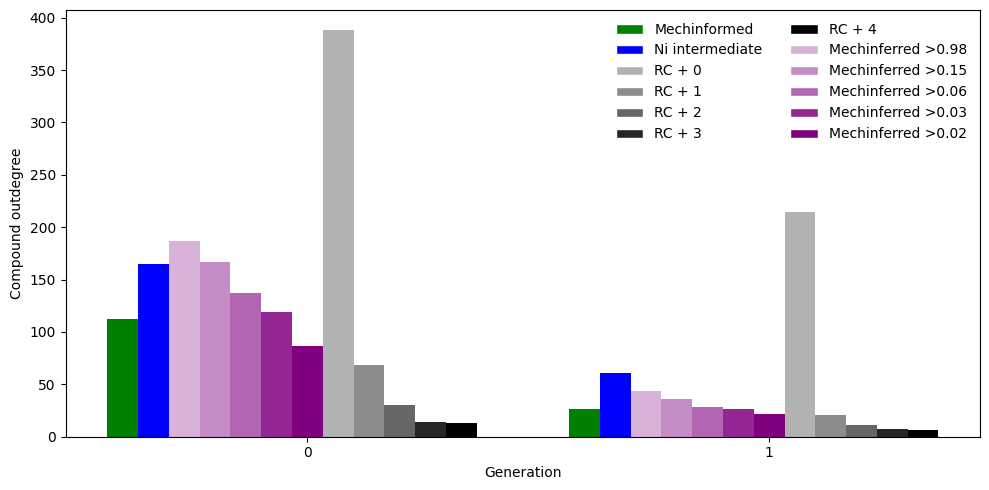

In [48]:
# Fan out clustered bar graph

gens = cpd_df.gen.unique()
scl_space = 1.5
n_bars = len(exp_labels)
width = 0.1

fig, ax = plt.subplots(figsize=(10, 5))

for gen in gens:
    ctr = gen * scl_space
    for i in range(n_bars):
        tick = ctr - ((n_bars * width) / 2) + (i * width)
        exp_name = exp_names[i]
        mean_fan_out = cpd_df.loc[(cpd_df["gen"] == gen) & (cpd_df["expansion"] == exp_name), "fan_out"]["mean"].values[0]
        label = exp_labels[exp_name]
        color = colors[exp_name]
        ax.bar(tick, height=mean_fan_out, width=width, color=color, label=label)
ax.set_xticks(gens * scl_space)
ax.set_xticklabels(gens.astype(int))

ax.set_xlabel("Generation")
ax.set_ylabel("Compound outdegree")
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_fan_out_clustered_bar_graph.svg", format="svg")
plt.show()
        

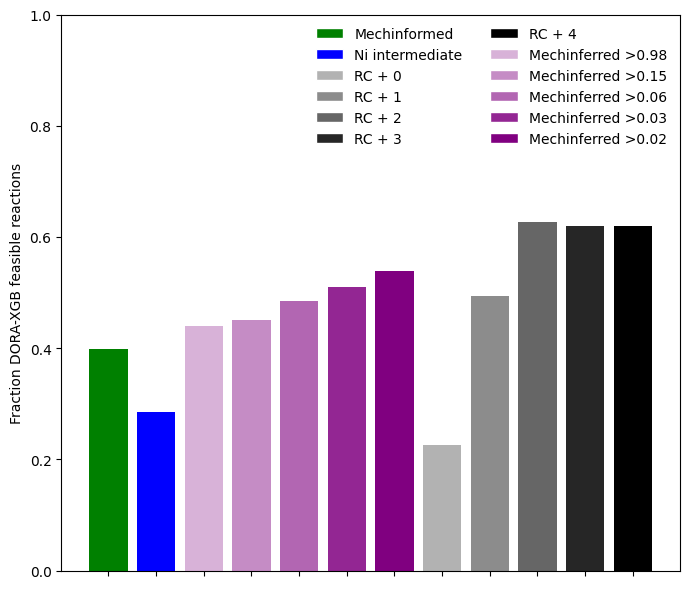

In [49]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylim(0, 1.0)
ax.set_ylabel("Fraction DORA-XGB feasible reactions")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_feasibility_bar_graph.svg", format="svg")
plt.show()

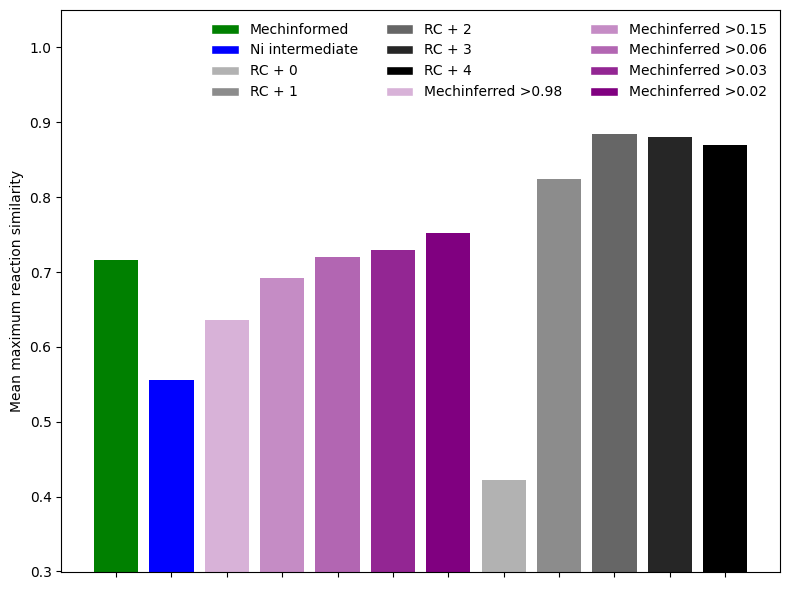

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.8
for exp_name in exp_names:
    mean = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=mean, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=3, frameon=False, fontsize=10)
ax.set_ylim(0.3, 1.05)
ax.set_ylabel("Mean maximum reaction similarity")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_max_rxn_sim_bar_graph.svg", format="svg")
plt.show()

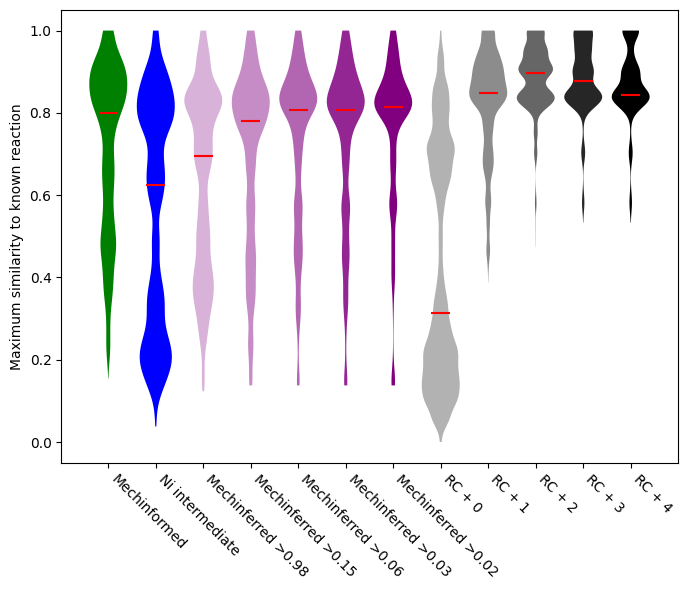

In [51]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
data = []
xticklabels = []
positions = []
_colors = []
_alphas = []
for i, exp_name in enumerate(exp_names):
    data.append(rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"])
    xticklabels.append(exp_labels[exp_name])
    positions.append(i)
    _colors.append(tuple(elt for elt in colors[exp_name][:-1]))
    _alphas.append(colors[exp_name][-1])  # store alpha for violin plot

vparts = ax.violinplot(data, positions=positions, widths=width, showmeans=False, showmedians=True, showextrema=False)

for color, alpha, vp in zip(_colors, _alphas, vparts['bodies']):
    vp.set_facecolor(color)
    # vp.set_edgecolor('black')
    vp.set_alpha(alpha)

vparts["cmedians"].set_color("red")

ax.set_xticks(positions)
ax.set_xticklabels(labels=xticklabels, rotation=-45, ha='left')
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel("Maximum similarity to known reaction")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_max_rxn_sim_violin_plot.svg", format="svg")
plt.show()

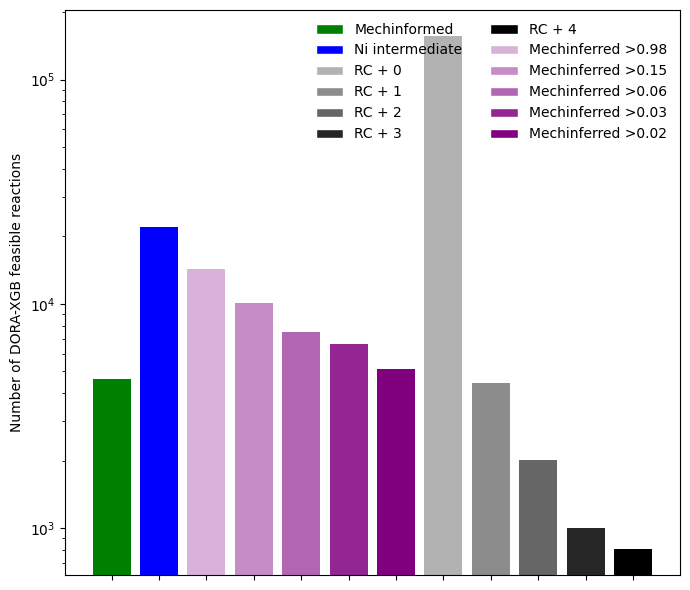

In [52]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac * tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Number of DORA-XGB feasible reactions")
ax.set_yscale('log')
plt.tight_layout()
plt.show()

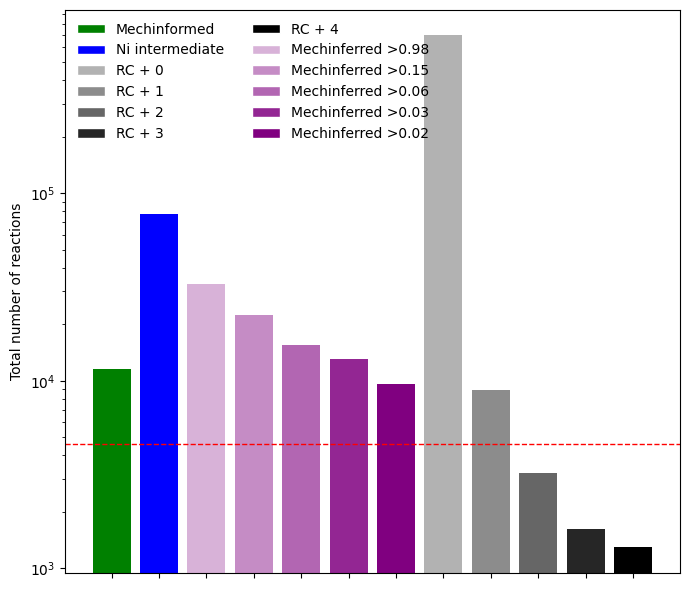

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper left', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_bar_graph.svg", format="svg")
plt.show()

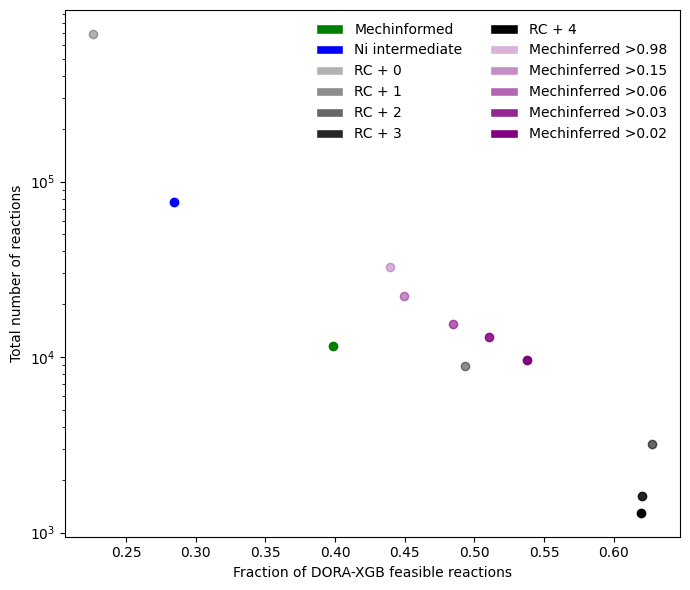

In [56]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.plot(feas_frac, tot_rxns, marker='o', color=color)

ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Fraction of DORA-XGB feasible reactions")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_feasibility.svg", format="svg")
plt.show()

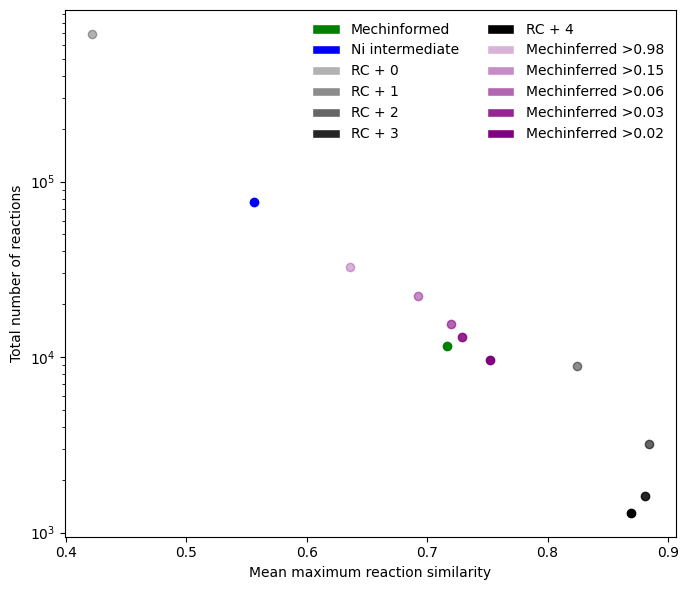

In [57]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    mean_max_sim = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.plot(mean_max_sim, tot_rxns, marker='o', color=color)

ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Mean maximum reaction similarity")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_mean_max_rxn_sim.svg", format="svg")
plt.show()

In [ ]:
rxn_df.sort_values(by="max_rxn_sim", ascending=False)

,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,known
25986,R33fcf0c26e92c5c012a59de237557eb58886cc824153e...,NC(Cc1ccc(OC2OC(CO)C(O)C(O)C2O)cc1)C(=O)O.O=c1...,[NH2:1][CH:2]([CH2:3][c:4]1[cH:5][cH:6][c:7]([...,0,1.0,O=C(O)C=Cc1ccc(OC2OC(CO)C(O)C(O)C2O)cc1.O=c1cc...,11421,[1229_1],2_steps_ccm_aa_rules_mechinferred_dt_98_rules_...,False
7074,R07ce9513e953b3d8a890ca22f285d137134cf64813076...,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,0,1.0,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,1134,"[7966_0, 5717_0]",2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w...,False
7152,Re4dcc87e12b1154eaa85d42f2eca87200b8fb0c465b22...,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,0,1.0,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,1263,"[7966_0, 5717_0]",2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w...,False
27042,R9a16b243a55ec3c75fd009b94575edca72c6be5f99971...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C...,[O:1]=[c:2]1[cH:3][cH:4][n:5]([CH:6]2[O:7][CH:...,1,1.0,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C...,4024,"[561_1, 28_1]",2_steps_ccm_aa_rules_mechinferred_dt_98_rules_...,False
1876,Re34545bf33a2e005b93fe3c76d115482dbf82c274c54d...,C=CC(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)...,[CH2:1]=[CH:2][C:3](=[O:4])[OH:5].[NH2:6][C:7]...,0,1.0,C=CC(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)...,6188,"[6028_0, 113_0, 986_0]",2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w...,False
...,...,...,...,...,...,...,...,...,...,...
541392,R727bd81ba93f2d8d6238028079b09dffb1c7c761c4030...,COC(=O)C(N)Cc1c[nH]c2ccccc12>>Cc1ccc2c(CC(N)C(...,[CH3:1][O:2][C:3](=[O:4])[CH:5]([NH2:6])[CH2:7...,1,0.0,O=P(O)(O)OCC1OC(O)C(O)C(O)C1O>>O=P(O)(O)OC1C(O...,5290,[960_0],2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreact...,False
541393,R5300a043762daa40cefbdcf8c427f4f51199ce2f677d5...,COC(=O)C(N)Cc1c[nH]c2ccccc12>>Cc1ccc2[nH]cc(CC...,[CH3:1][O:2][C:3](=[O:4])[CH:5]([NH2:6])[CH2:7...,1,0.0,O=P(O)(O)OCC1OC(O)C(O)C(O)C1O>>O=P(O)(O)OC1C(O...,5290,[960_0],2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreact...,False
541394,Raa0712ce73b2081db282c54fafa0aa2595c28b879fa3f...,COC(=O)C(N)Cc1c[nH]c2ccccc12>>Cc1cccc2[nH]cc(C...,[CH3:1][O:2][C:3](=[O:4])[CH:5]([NH2:6])[CH2:7...,1,0.0,O=P(O)(O)OCC1OC(O)C(O)C(O)C1O>>O=P(O)(O)OC1C(O...,5290,[960_0],2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreact...,False
550127,R0e056873fa66d3397c9e7ee2ee1dedb09497724cc8e99...,NC(CC1=CN=C2C=CC=CC12O)C(O)O>>N=C1C=CC=CC1(O)C...,[NH2:1][CH:2]([CH2:3][C:4]1=[CH:5][N:6]=[C:7]2...,0,0.0,O=C(O)Nc1cncn1C1OC(COP(=O)(O)O)C(O)C1O>>Nc1c(C...,2715,[224_0],2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreact...,False


Venn diagrams

In [2]:
mechinfo_rids = rxn_df.loc[rxn_df["expansion"] == "2_steps_250728_benchmark_starters_mechinformed_rules_w_coreactants_aplusb_True.pk", "id"].values
mechinfo_rids = set(mechinfo_rids)
rc_plus_1_rids = rxn_df.loc[rxn_df["expansion"] == "2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk", "id"].values
rc_plus_1_rids = set(rc_plus_1_rids)

print(len(mechinfo_rids))
print(len(rc_plus_1_rids))

NameError: name 'rxn_df' is not defined

In [76]:
mechinfo_only = mechinfo_rids - rc_plus_1_rids
print(len(mechinfo_only))
rc_info_only = rc_plus_1_rids - mechinfo_rids
print(len(rc_info_only))

mechinfo_rc_plus_1_intersect = mechinfo_rids & rc_plus_1_rids
print(len(mechinfo_rc_plus_1_intersect))

7852
5209
3741


In [ ]:

pk = Pickaxe()
pk.load_pickled_pickaxe(Path(cfg.interim_data) / "2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk")

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk pickled data.
Loaded 6629 compounds
Loaded 11711 reactions
Loaded 757 operators
Loaded 66 coreactants
Loaded 2 generation
Took 0.09916257858276367


[13:07:20] WARNING: not removing hydrogen atom without neighbors


In [170]:
starters = set()

for cid, cpd in pk.compounds.items():
    if cpd["Type"] == "Starting Compound":
        starters.add(cpd["SMILES"])

In [176]:
mechinfo_only_df = rxn_df.loc[
    (rxn_df["expansion"] == "2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk") & (rxn_df["id"].isin(mechinfo_only))
]

mechinfo_only_df = mechinfo_only_df.sort_values(by=["dxgb_label", "max_rxn_sim"], ascending=False)
print(len(mechinfo_only_df))
mechinfo_only_df_first_gen = mechinfo_only_df.loc[mechinfo_only_df["smarts"].apply(lambda x: any([elt in starters for elt in x.split('>>')[0].split('.')]))].reset_index()
print(len(mechinfo_only_df_first_gen))
mechinfo_only_df_first_gen.head()

7852
2680


,index,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,known
0,97,Rc1d16b2f24a2c9ad05cf3eed4ffe2d1ac938d51a93a35...,CC(=O)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)...,[CH3:1][C:2](=[O:3])[C:4](=[O:5])[OH:6].[NH2:7...,1,1.000000,CC(=O)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)...,2779,[114_0],2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
1,2969,R5a5cc88637c00f9034e0d0cb68e94d1c5e24421ce4dba...,CC(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O...,[CH3:1][CH:2]([OH:3])[OH:4].[NH2:5][c:6]1[n:7]...,1,0.968750,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
2,4708,R8fa2d005dd0d1398abac63b6f657600ed6178a3b174cf...,NC(CC(=O)NP(=O)(O)O)C(=O)O.Nc1ncnc2c1ncn2C1OC(...,[NH2:1][CH:2]([CH2:3][C:4](=[O:5])[NH:6][P:7](...,1,0.939826,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
3,6584,R73501d6b2a750d208747db8d3a4afebdd3c89f9b21186...,CSCCC(NP(=O)(O)O)C(=O)O.Nc1ncnc2c1ncn2C1OC(COP...,[CH3:1][S:2][CH2:3][CH2:4][CH:5]([NH:6][P:7](=...,1,0.939826,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
4,8795,Ra4bc5932324f20abc7eddde141c0d4de72bed4e8cbdc6...,NC(CCCCNP(=O)(O)O)C(=O)O.Nc1ncnc2c1ncn2C1OC(CO...,[NH2:1][CH:2]([CH2:3][CH2:4][CH2:5][CH2:6][NH:...,1,0.939826,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False


In [180]:
def show_rxn_info(idx):
    row = mechinfo_only_df_first_gen.iloc[idx]
    print(row["id"])
    print("Predicted:")
    display(SVG(draw_reaction(row["smarts"])))
    print("-" * 50)
    print("Nearest analogue:")
    display(SVG(draw_reaction(row["nearest_analogue"])))

srt_idx = mechinfo_only_df_first_gen.index
interact(show_rxn_info, idx=widgets.Dropdown(options=srt_idx, value=srt_idx[0]))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.show_rxn_info(idx)>

In [183]:
rc1exp = Pickaxe()
rc1exp.load_pickled_pickaxe(Path(cfg.interim_data) / "2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk")

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk pickled data.
Loaded 5756 compounds
Loaded 9210 reactions
Loaded 3853 operators
Loaded 71 coreactants
Loaded 2 generation
Took 0.4062004089355469


[14:24:25] WARNING: not removing hydrogen atom without neighbors


In [184]:
rc1exp.reactions['Rc1d16b2f24a2c9ad05cf3eed4ffe2d1ac938d51a93a35ed469e573297dea6da9']

KeyError: 'Rc1d16b2f24a2c9ad05cf3eed4ffe2d1ac938d51a93a35ed469e573297dea6da9'